In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [40]:
import colorcet as cc

In [61]:
import ssht_numba as sshtn

In [41]:
ccc = cc.m_cyclic_grey_15_85_c0_s25_r

In [2]:
plt.rcParams['figure.figsize'] = [10,8]

In [3]:
from RIMEz import sky_models, beam_models, rime_funcs, utils, management

In [101]:
array_latitude = utils.HERA_LAT
array_longitude = utils.HERA_LON
array_height = utils.HERA_HEIGHT

JD_INIT = 2458529.500000 # no particular signifigance
era_init = 2*np.pi - array_longitude + 2*2*np.pi/86164.

initial_time_sample_jd = utils.era2JD(era_init, JD_INIT)

integration_time = 0.

frequency_samples_hz = 1e6*np.linspace(140.,160.,201, endpoint=True)

antenna_positions_meters = np.array([
    [0.,0.,0.],
    [60.,0.,0.]
])

antenna_pairs_used, u2a, a2u = utils.get_minimal_antenna_set(antenna_positions_meters, precision=3)

antenna_beam_function_map = np.zeros(antenna_positions_meters.shape[0], dtype=np.int64)

integral_kernel_cutoff = utils.kernel_cutoff_estimate(
                            np.amax(u2a.keys()),
                            np.amax(frequency_samples_hz),
                            width_estimate=100)


In [102]:
delta_era_axis = np.linspace(0., 2*np.pi, 8052, endpoint=False)
jd0 = initial_time_sample_jd
era_axis = delta_era_axis + utils.JD2era_tot(jd0)
time_sample_jds = np.array(map(lambda era: utils.era2JD(era, jd0), era_axis))

In [103]:
parameters = {
    'array_latitude': array_latitude,
    'array_longitude': array_longitude,
    'array_height': array_height,
    'initial_time_sample_jd': initial_time_sample_jd,
    'integration_time': integration_time,
    'frequency_samples_hz': frequency_samples_hz,
    'antenna_positions_meters': antenna_positions_meters,
    'antenna_pairs_used': antenna_pairs_used,
    'antenna_beam_function_map': antenna_beam_function_map,
    'integral_kernel_cutoff': integral_kernel_cutoff,
    'time_sample_jds': time_sample_jds
}

In [7]:
beam_data_file_path = '/users/zmartino/zmartino/beam_data_from_nicolas/HERA_dipole_beams_spin1_model.h5'

beam_funcs = beam_models.model_data_to_spline_beam_func(
                beam_data_file_path,
                frequency_samples_hz,
                L_synth=180,
                indexed=True)

In [8]:
Slm = sky_models.diffuse_sky_model_from_GSM2008(1e-6*frequency_samples_hz)
Slm = Slm.reshape(Slm.shape + (1,))

In [104]:
VC = management.VisibilityCalculation(parameters, beam_funcs, Slm)

In [105]:
VC.compute_time_series()

In [106]:
VC.V.shape

(8052, 201, 2, 2, 2)

In [62]:
zero_index = sshtn.elm2ind(0,0)

In [66]:
Slm_nomono = np.copy(Slm)
Slm_nomono[:,zero_index] = 0.

In [107]:
VC_nomono = management.VisibilityCalculation(parameters, beam_funcs, Slm_nomono)

In [108]:
%%time
VC_nomono.compute_time_series()

CPU times: user 9min 55s, sys: 8min 27s, total: 18min 23s
Wall time: 1min 20s


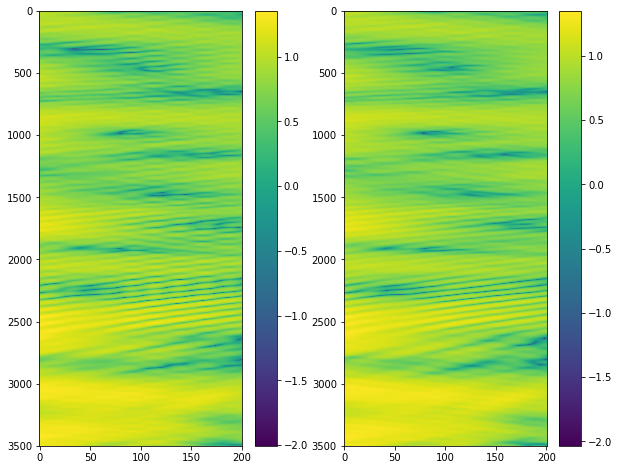

In [111]:
fig = plt.figure()
ax = fig.add_subplot(121)
img = ax.imshow(np.log10(np.abs(VC.V[2000:5500,:,1,0,0])), aspect='auto')
plt.colorbar(img)

ax = fig.add_subplot(122)
img = ax.imshow(np.log10(np.abs(VC_nomono.V[2000:5500,:,1,0,0])), aspect='auto')
plt.colorbar(img)

plt.show()

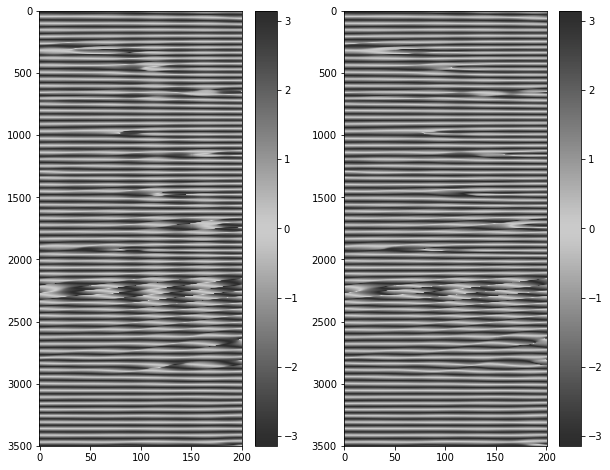

In [112]:
fig = plt.figure()
ax = fig.add_subplot(121)
img = ax.imshow((np.angle(VC.V[2000:5500,:,1,0,0])), cmap=ccc, aspect='auto')
plt.colorbar(img)

ax = fig.add_subplot(122)
img = ax.imshow((np.angle(VC_nomono.V[2000:5500,:,1,0,0])), cmap=ccc, aspect='auto')
plt.colorbar(img)

plt.show()

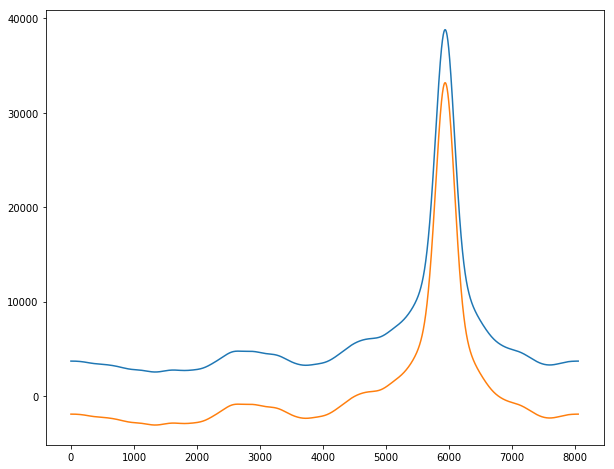

In [113]:
plt.plot(np.real(VC.V[:,100,0,0,0]))
plt.plot(np.real(VC_nomono.V[:,100,0,0,0]))

plt.show()

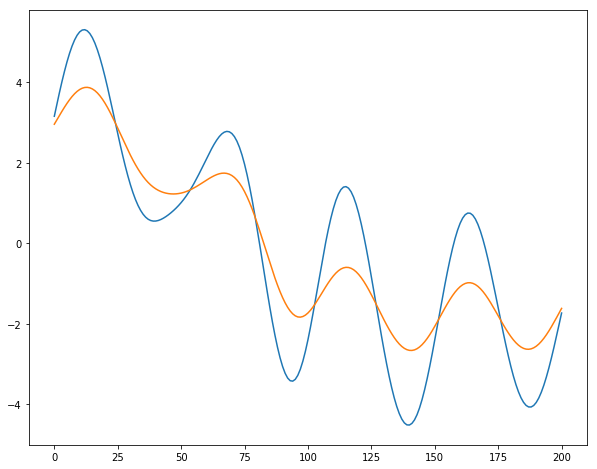

In [114]:
plt.plot(np.real(VC.V[4000,:,1,0,0]))
plt.plot(np.real(VC_nomono.V[4000,:,1,0,0]))

plt.show()

In [115]:
# ~10 hours of Vokes-I 30m EW baseline

VI = np.einsum('...aa', VC.V)[2000:5500,:,1]
VI_nm = np.einsum('...aa', VC_nomono.V)[2000:5500,:,1]

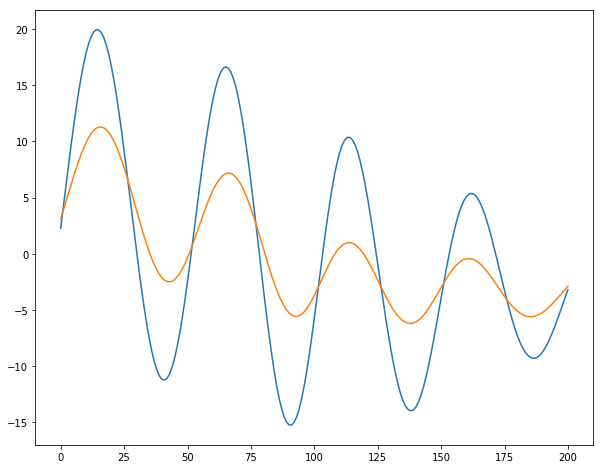

In [116]:
plt.plot(np.real(VI[2000,:]))
plt.plot(np.real(VI_nm[2000,:]))

plt.show()

In [117]:
from scipy.signal.windows import blackmanharris

In [118]:
W = blackmanharris(VI.shape[1], sym=False)

In [119]:
VI_ft = np.fft.fftshift(np.fft.ifft(W[None,:]*VI, axis=1), axes=1)
VI_nm_ft = np.fft.fftshift(np.fft.ifft(W[None,:]*VI_nm, axis=1), axes=1)

In [120]:
VI_ft.shape

(3500, 201)

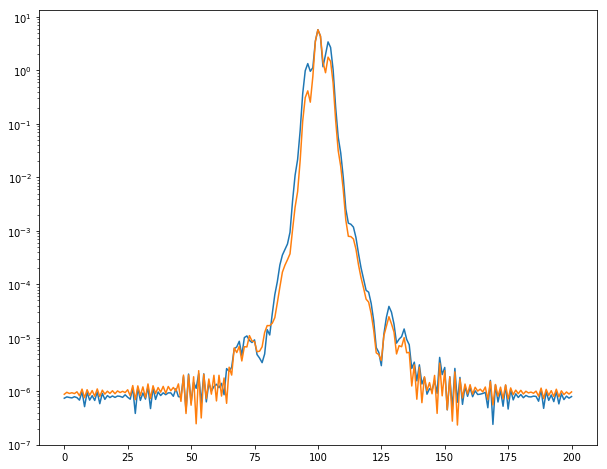

In [121]:
plt.plot(np.abs(VI_ft[2000]))
plt.plot(np.abs(VI_nm_ft[2000]))

plt.yscale('log')
plt.show()

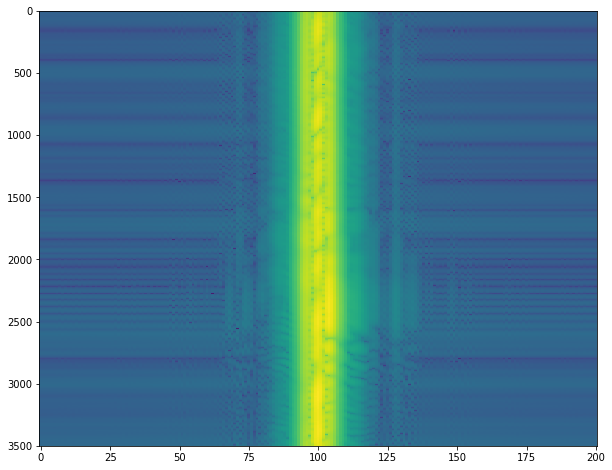

In [122]:
plt.imshow(np.log10(np.abs(VI_ft)), aspect='auto')
plt.show()

In [123]:
dspec_I = np.mean(np.abs(VI_ft)**2., axis=0)
dspec_I_nm = np.mean(np.abs(VI_nm_ft)**2., axis=0)

In [126]:
tau_axis = np.fft.fftfreq(VI.shape[1], d=np.diff(frequency_samples_hz)[0])*1e9
tau_axis = np.fft.fftshift(tau_axis)

In [128]:
tau_g = 1e9 * 60./2.99e8

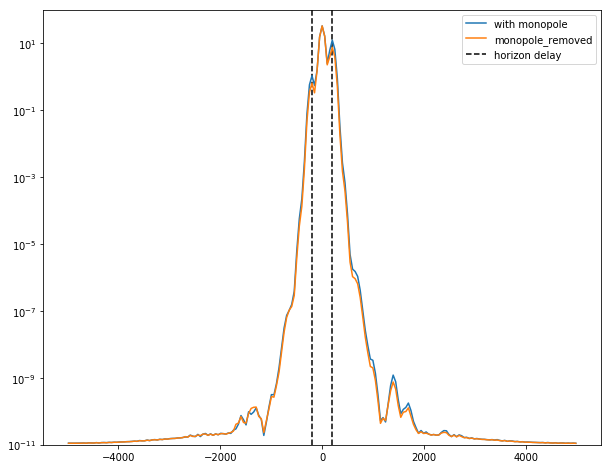

In [136]:
plt.plot(tau_axis, dspec_I, label='with monopole')
plt.plot(tau_axis, dspec_I_nm, label='monopole_removed')

plt.yscale('log')
plt.vlines([-tau_g, tau_g], ymin=1e-16,ymax=1e4, linestyles='--', label='horizon delay')
plt.ylim(1e-11,1e2)
plt.legend()
plt.show()

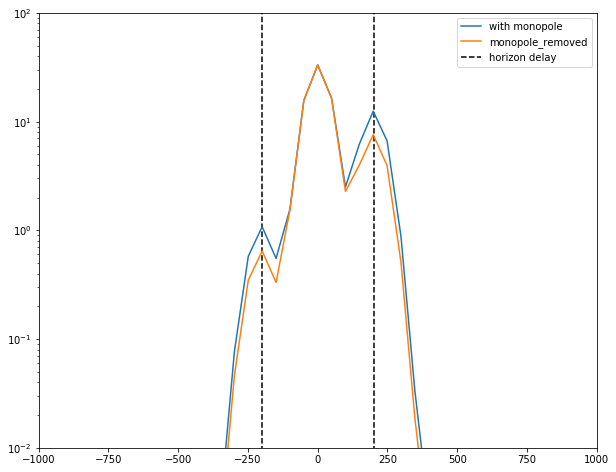

In [135]:
plt.plot(tau_axis, dspec_I, label='with monopole')
plt.plot(tau_axis, dspec_I_nm, label='monopole_removed')

plt.yscale('log')
plt.vlines([-tau_g, tau_g], ymin=1e-16,ymax=1e4, linestyles='--', label='horizon delay')
plt.ylim(1e-2,1e2)
plt.xlim(-1000.,1000.)
plt.legend()
plt.show()